In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [2]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file='tree.dot', class_names=iris_data.target_names, feature_names=iris_data.feature_names, impurity=True, filled=True)

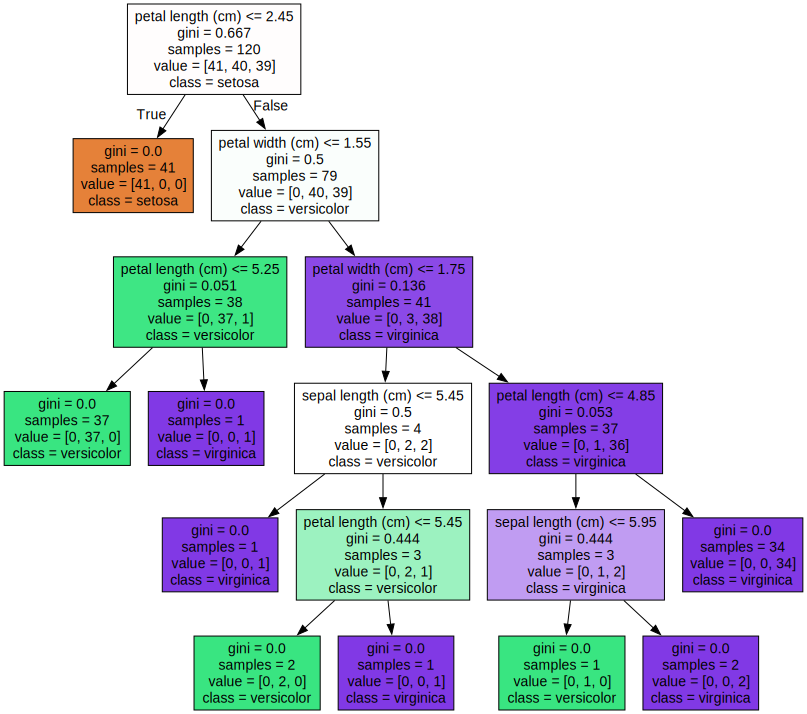

In [3]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Feature importances:
[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


<Axes: >

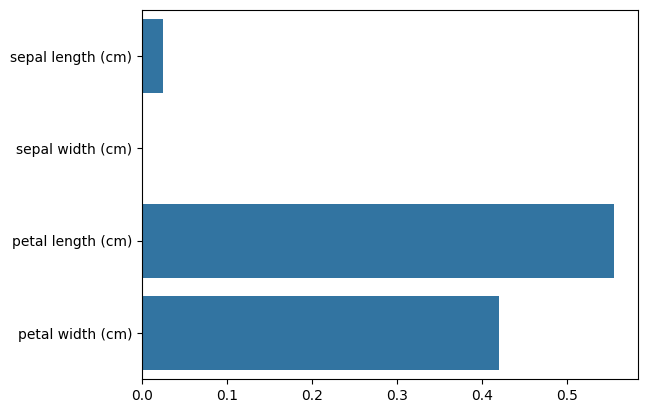

In [4]:
import seaborn as sns
import numpy as np
%matplotlib inline

print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_, 3)))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

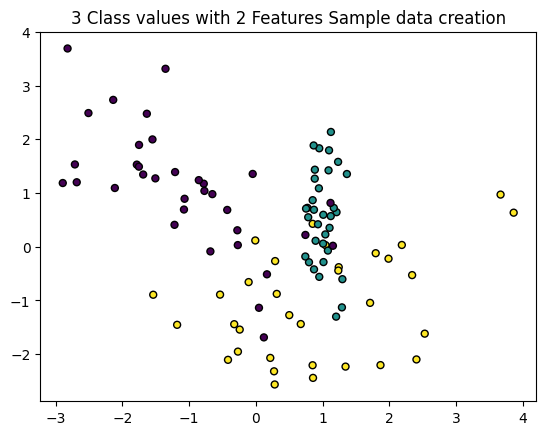

In [5]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('3 Class values with 2 Features Sample data creation')

X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state=0)

plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, edgecolors='k')

In [6]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

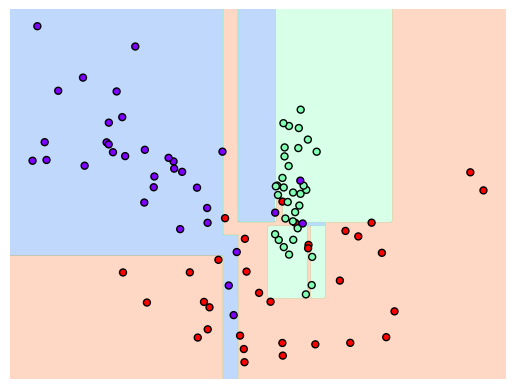

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

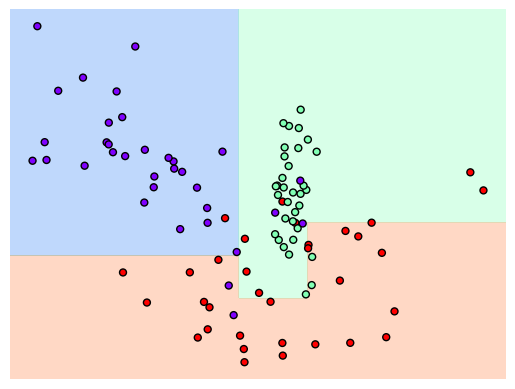

In [8]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=6, random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [10]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [11]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [12]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [13]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [14]:
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 156, 'splitter': 'best'}


In [16]:
from sklearn.model_selection import GridSearchCV

params = {
      'max_depth': [6, 8, 10, 12, 16, 20, 24]
    , 'min_samples_split': [16]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=2)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..................max_depth=6, min_samples_split=16; total time=   1.6s
[CV] END ..................max_depth=6, min_samples_split=16; total time=   1.6s
[CV] END ..................max_depth=6, min_samples_split=16; total time=   1.6s
[CV] END ..................max_depth=6, min_samples_split=16; total time=   1.6s
[CV] END ..................max_depth=6, min_samples_split=16; total time=   1.6s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.0s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END .................max_depth=10, min_samples_split=16; total time=   2.5s
[CV] END .................max_depth=10, min_sampl

In [17]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [18]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


In [19]:
params = {
      'max_depth': [8, 12, 16, 20]
    , 'min_samples_split': [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=2)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.0s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=16; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   2.0s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   2.1s
[CV] END ..................max_depth=8, min_samples_split=24; total time=   2.1s
[CV] END .................max_depth=12, min_samples_split=16; total time=   3.0s
[CV] END .................max_depth=12, min_sampl

In [20]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


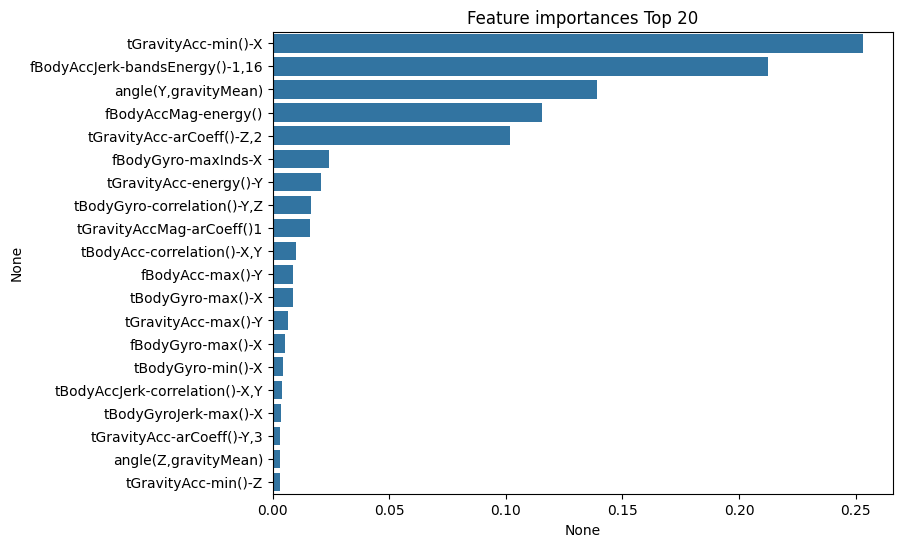

In [21]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [22]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [23]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9196


In [25]:
from sklearn.model_selection import GridSearchCV

params = {
      'max_depth': [8, 16, 24]
    , 'min_samples_leaf': [1, 6, 12]
    , 'min_samples_split': [2, 8, 16]
}
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9165


In [26]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9260


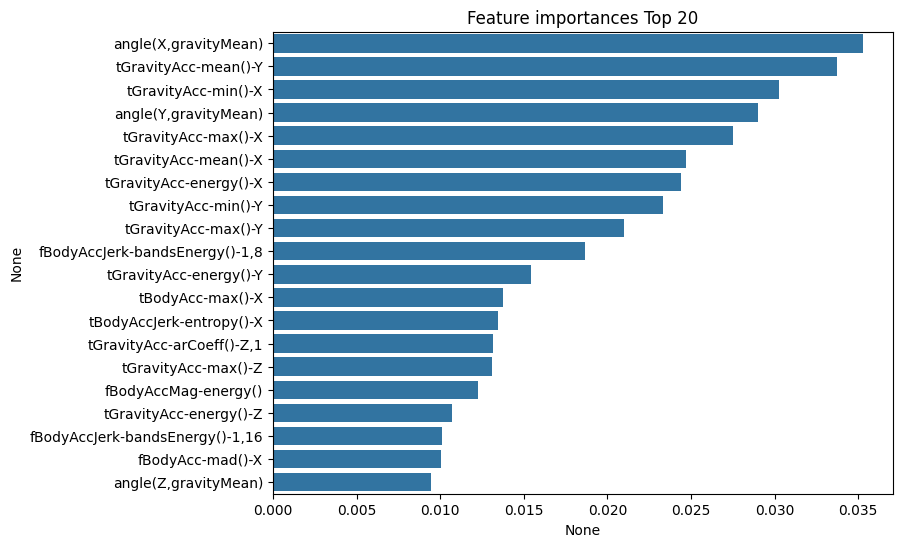

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초 '.format(time.time() - start_time))

GBM 정확도: 0.9393
GBM 수행 시간: 707.0 초 


In [29]:
import xgboost as xgb
from xgboost import XGBClassifier

In [30]:
import xgboost

print(xgboost.__version__)

2.1.0


In [31]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [32]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [33]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
      X_features
    , y_label
    , test_size=0.2
    , random_state=156
)

X_tr, X_val, y_tr, y_val = train_test_split(
      X_train
    , y_train
    , test_size=0.1
    , random_state=156
)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [34]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [35]:
params = {
      'max_depth': 3
    , 'eta': 0.05
    , 'objective': 'binary:logistic'
    , 'eval_metric': 'logloss'
}
num_rounds = 400

In [36]:
eval_list = [(dtr, 'train'), (dval, 'eval')]

xgb_model = xgb.train(
      params=params
    , dtrain=dtr
    , num_boost_round=num_rounds
    , early_stopping_rounds=50
    , evals=eval_list
    )

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [37]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [38]:
# 불균형 데이터 셋
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [39]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1: 0.9740, AUC: 0.9965


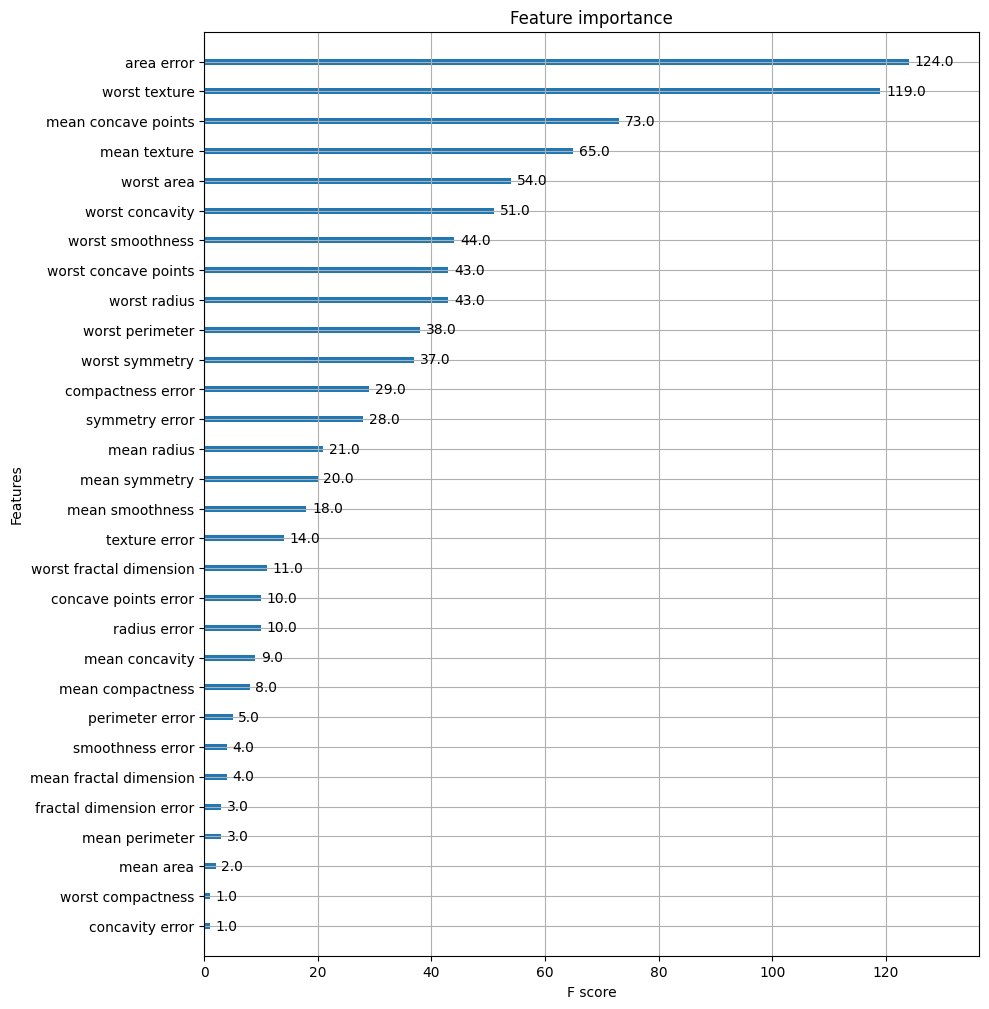

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

In [41]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(
      n_estimators=400
    , learning_rate=0.05
    , max_depth=3
    , eval_metric='logloss'
    )
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [42]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9954


In [43]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(
      n_estimators=400
    , learning_rate=0.05
    , max_depth=3
    , early_stopping_rounds=50
    , eval_metric='logloss'
)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(
      X_tr
    , y_tr
    , eval_set=evals
    , verbose=True
)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

In [44]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1: 0.9740, AUC: 0.9961


In [45]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(
      n_estimators=400
    , learning_rate=0.05
    , max_depth=3
    , early_stopping_rounds=10
    , eval_metric='logloss'
)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(
      X_tr
    , y_tr
    , eval_set=evals
    , verbose=True
)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

In [46]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(
      data=dataset.data
    , columns=dataset.feature_names
)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
      X_features
    , y_label
    , test_size=0.2
    , random_state=156
)

X_tr, X_val, y_tr, y_val = train_test_split(
      X_train
    , y_train
    , test_size=0.1
    , random_state=156
)

lgbm_wrapper = LGBMClassifier(
      n_estimators=400
    , learning_rate=0.05
    , early_stopping_rounds=50
    , eval_metric='logloss'
    , verbose=2
)

evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(
      X_tr
    , y_tr
    , eval_set=evals
)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.003912
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.000152 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Curr

In [47]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

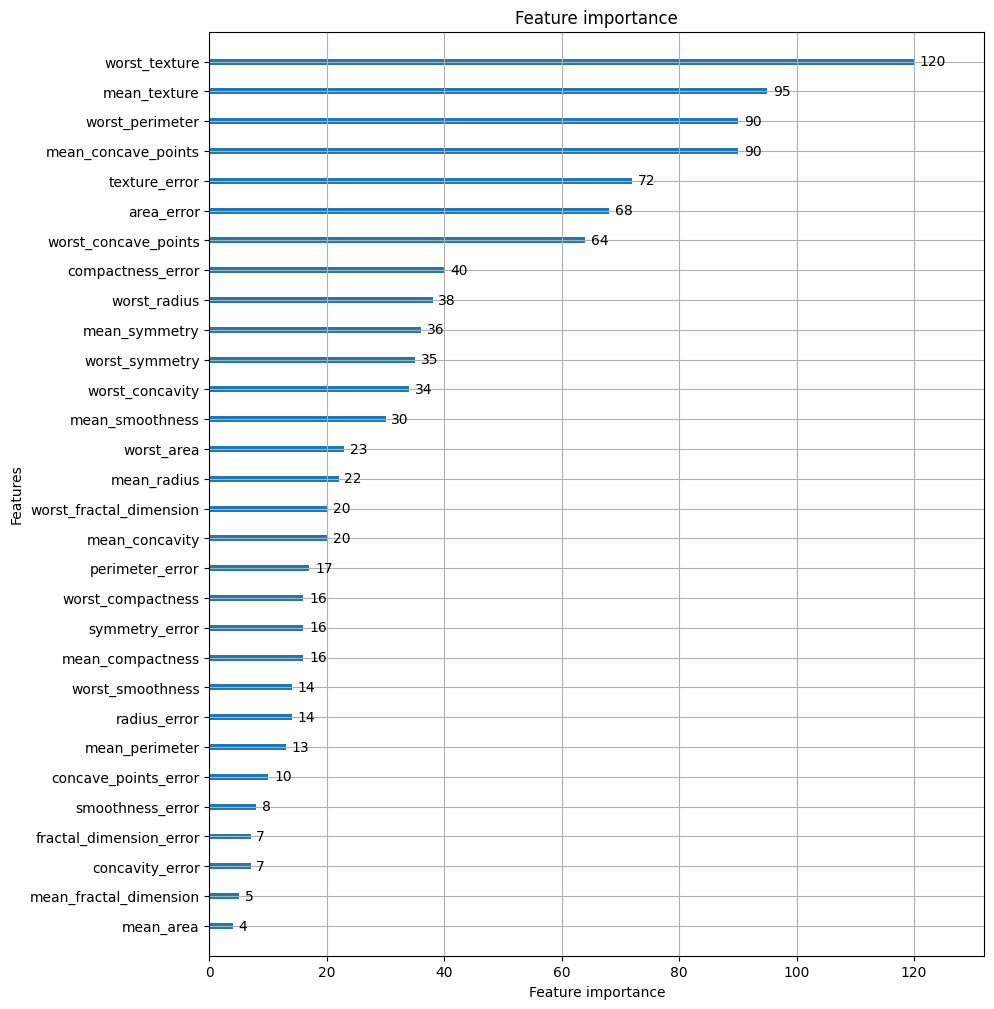

In [48]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

In [49]:
params = {
      'max_depth': [10, 20, 30, 40, 50]
    , 'num_leaves': [35, 45, 55, 65]
    , 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
    , 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]
    , 'min_child_weight': [10, 20, 30, 40]
    , 'reg_alpha': [0.01, 0.05, 0.1]
}

In [50]:
from hyperopt import hp

search_space = {
      'x': hp.quniform('x', -10, 10, 1)
    , 'y': hp.quniform('y', -15, 15, 1)
}

In [51]:
from hyperopt import STATUS_OK

def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x ** 2 - 20 * y
    
    return retval

In [52]:
from hyperopt import fmin, tpe, Trials
trial_val = Trials()

best_01 = fmin(
      fn=objective_func
    , space=search_space
    , algo=tpe.suggest
    , max_evals=5
    , trials=trial_val
    , rstate=np.random.default_rng(seed=0)
)
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 833.46trial/s, best loss: -224.0]
best: {'x': np.float64(-4.0), 'y': np.float64(12.0)}


In [53]:
trial_val = Trials()

best_02 = fmin(
      fn=objective_func
    , space=search_space
    , algo=tpe.suggest
    , max_evals=20
    , trials=trial_val
    , rstate=np.random.default_rng(seed=0)
)
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 666.53trial/s, best loss: -296.0]
best: {'x': np.float64(2.0), 'y': np.float64(15.0)}


In [54]:
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [55]:
print(trial_val.vals)

{'x': [np.float64(-6.0), np.float64(-4.0), np.float64(4.0), np.float64(-4.0), np.float64(9.0), np.float64(2.0), np.float64(10.0), np.float64(-9.0), np.float64(-8.0), np.float64(-0.0), np.float64(-0.0), np.float64(1.0), np.float64(9.0), np.float64(6.0), np.float64(9.0), np.float64(2.0), np.float64(-2.0), np.float64(-4.0), np.float64(7.0), np.float64(-0.0)], 'y': [np.float64(5.0), np.float64(10.0), np.float64(-2.0), np.float64(12.0), np.float64(1.0), np.float64(15.0), np.float64(7.0), np.float64(-10.0), np.float64(0.0), np.float64(-5.0), np.float64(-3.0), np.float64(2.0), np.float64(4.0), np.float64(10.0), np.float64(3.0), np.float64(3.0), np.float64(-14.0), np.float64(-8.0), np.float64(11.0), np.float64(-0.0)]}


In [57]:
import pandas as pd

losses = [loss_dict['loss'] for loss_dict in trial_val.results]

result_df = pd.DataFrame(
    {
          'x': trial_val.vals['x']
        , 'y': trial_val.vals['y']
        , 'losses': losses
    }
)
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
      X_features
    , y_label
    , test_size=0.2
    , random_state=156
)

In [58]:
from hyperopt import hp

xgb_search_space = {
      'max_depth': hp.quniform('max_depth', 5, 20, 1)
    , 'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1)
    , 'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
    , 'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

In [59]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
    xgb_clf = XGBClassifier(
          n_estimators=100
        , max_depth=int(search_space['max_depth'])
        , min_child_weight=int(search_space['min_child_weight'])
        , learning_rate=search_space['learning_rate']
        , colsample_bytree=search_space['colsample_bytree']
        , eval_metric='logloss'
    )
    accuracy = cross_val_score(
          xgb_clf
        , X_train
        , y_train
        , scoring='accuracy'
        , cv=3
    )
    
    return {'loss': -1 * np.mean(accuracy), 'status': STATUS_OK}

In [61]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(
      fn=objective_func
    , space=xgb_search_space
    , algo=tpe.suggest
    , max_evals=50
    , trials=trial_val
    , rstate=np.random.default_rng(seed=9)
)
print('best:', best)

100%|██████████| 50/50 [00:13<00:00,  3.68trial/s, best loss: -0.9714621819449286]
best: {'colsample_bytree': np.float64(0.5036717216371022), 'learning_rate': np.float64(0.19808959234346474), 'max_depth': np.float64(12.0), 'min_child_weight': np.float64(1.0)}


In [63]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'
      .format(round(best['colsample_bytree'], 5), round(best['learning_rate'], 5), int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.50367, learning_rate:0.19809, max_depth:12, min_child_weight:1


In [68]:
xgb_wrapper = XGBClassifier(
      n_estimators=400
    , learning_rate=round(best['learning_rate'], 5)
    , max_depth=int(best['max_depth'])
    , min_child_weight=int(best['min_child_weight'])
    , colsample_bytree=round(best['colsample_bytree'], 5)
    , early_stopping_rounds=50
    , eval_metric='logloss'
)

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(
      X_tr
    , y_tr
    , eval_set=evals
    , verbose=True
)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.51050	validation_1-logloss:0.54091
[1]	validation_0-logloss:0.40643	validation_1-logloss:0.46300
[2]	validation_0-logloss:0.32978	validation_1-logloss:0.40989
[3]	validation_0-logloss:0.27058	validation_1-logloss:0.37503
[4]	validation_0-logloss:0.22553	validation_1-logloss:0.35076
[5]	validation_0-logloss:0.19073	validation_1-logloss:0.32314
[6]	validation_0-logloss:0.16231	validation_1-logloss:0.30427
[7]	validation_0-logloss:0.13942	validation_1-logloss:0.29606
[8]	validation_0-logloss:0.12122	validation_1-logloss:0.28180
[9]	validation_0-logloss:0.10559	validation_1-logloss:0.27067
[10]	validation_0-logloss:0.09315	validation_1-logloss:0.26813
[11]	validation_0-logloss:0.08209	validation_1-logloss:0.26516
[12]	validation_0-logloss:0.07277	validation_1-logloss:0.26080
[13]	validation_0-logloss:0.06506	validation_1-logloss:0.25770
[14]	validation_0-logloss:0.05796	validation_1-logloss:0.25109
[15]	validation_0-logloss:0.05245	validation_1-logloss:0.24523
[1

### 09 분류 실습 - 캐글 산탄데르 고객 만족 예측

##### 데이터 전처리

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv('./santander-customer-satisfaction/train.csv')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [70]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [71]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [72]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [73]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
      X_features
    , y_labels
    , test_size=0.2
    , random_state=0
)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [79]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

#### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [81]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(
      n_estimators=500
    , learning_rate=0.05
    , random_state=156
    , early_stopping_rounds=100
    , eval_metric='auc'
    )

xgb_clf.fit(
      X_tr
    , y_tr
    , eval_set=[(X_tr, y_tr), (X_val, y_val)]
    )

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85105	validation_1-auc:0.81965
[12]	validation_0-auc:0.85217	validation_1-auc:0.81999
[13]	validation_0-auc:0.85301	validation_1-auc:0.82049
[14]	validation_0-auc:0.85558	validation_1-auc:0.82210
[15]	validation_0-auc:0.85662	validation_1-auc:0.82288
[16]	validation_0-auc:0.85811	validation_1-auc:0.82380
[17]	validation_0-auc:0.85864	validation_1-auc:0.82365
[18]	validation_0-au

In [82]:
from hyperopt import hp

xgb_search_space = {
      'max_depth': hp.quniform('max_depth', 5, 15, 1)
    , 'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1)
    , 'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95)
    , 'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [87]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def objective_func(search_space):
    xgb_clf = XGBClassifier(
          n_estimators=100
        , max_depth=int(search_space['max_depth'])
        , min_child_weight=int(search_space['min_child_weight'])
        , colsample_bytree=search_space['colsample_bytree']
        , learning_rate=search_space['learning_rate']
        , early_stopping_rounds=30
        , eval_metric='auc'
    )
    
    roc_auc_list = []
    
    kf = KFold(n_splits=3)
    for tr_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
      
        xgb_clf.fit(
              X_tr
            , y_tr
            , eval_set=[(X_tr, y_tr), (X_val, y_val)]
        )
      
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
    
    return -1 * np.mean(roc_auc_list)

In [88]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(
      fn=objective_func
    , space=xgb_search_space
    , algo=tpe.suggest
    , max_evals=50
    , trials=trials
    , rstate=np.random.default_rng(seed=30)
)

print('best:', best)

[0]	validation_0-auc:0.82881	validation_1-auc:0.80070 
[1]	validation_0-auc:0.83453	validation_1-auc:0.80438 
[2]	validation_0-auc:0.84292	validation_1-auc:0.81324 
[3]	validation_0-auc:0.84498	validation_1-auc:0.81897 
[4]	validation_0-auc:0.84983	validation_1-auc:0.82234 
[5]	validation_0-auc:0.84837	validation_1-auc:0.81951 
[6]	validation_0-auc:0.85080	validation_1-auc:0.82130 
[7]	validation_0-auc:0.85006	validation_1-auc:0.81946 
[8]	validation_0-auc:0.85450	validation_1-auc:0.82299 
[9]	validation_0-auc:0.85690	validation_1-auc:0.82461 
[10]	validation_0-auc:0.85589	validation_1-auc:0.82306
[11]	validation_0-auc:0.85854	validation_1-auc:0.82426
[12]	validation_0-auc:0.86066	validation_1-auc:0.82551
[13]	validation_0-auc:0.86334	validation_1-auc:0.82818
[14]	validation_0-auc:0.86427	validation_1-auc:0.82894
[15]	validation_0-auc:0.86520	validation_1-auc:0.82924
[16]	validation_0-auc:0.86624	validation_1-auc:0.82979
[17]	validation_0-auc:0.86723	validation_1-auc:0.82960
[18]	valid

In [89]:
xgb_clf = XGBClassifier(
      n_estimators=500
    , learning_rate=round(best['learning_rate'], 5)
    , max_depth=int(best['max_depth'])
    , min_child_weight=int(best['min_child_weight'])
    , colsample_bytree=round(best['colsample_bytree'], 5)
    , early_stopping_rounds=100
    , eval_metric='auc'
)

xgb_clf.fit(
      X_tr
    , y_tr
    , eval_set=[(X_tr, y_tr), (X_val, y_val)]
)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.74411	validation_1-auc:0.72004
[1]	validation_0-auc:0.82527	validation_1-auc:0.80201
[2]	validation_0-auc:0.82090	validation_1-auc:0.79748
[3]	validation_0-auc:0.82036	validation_1-auc:0.79573
[4]	validation_0-auc:0.83397	validation_1-auc:0.81171
[5]	validation_0-auc:0.83131	validation_1-auc:0.80901
[6]	validation_0-auc:0.84018	validation_1-auc:0.81760
[7]	validation_0-auc:0.83882	validation_1-auc:0.81519
[8]	validation_0-auc:0.84578	validation_1-auc:0.82029
[9]	validation_0-auc:0.85104	validation_1-auc:0.82729
[10]	validation_0-auc:0.85044	validation_1-auc:0.82596
[11]	validation_0-auc:0.85476	validation_1-auc:0.82909
[12]	validation_0-auc:0.85515	validation_1-auc:0.82834
[13]	validation_0-auc:0.85884	validation_1-auc:0.83082
[14]	validation_0-auc:0.86069	validation_1-auc:0.83222
[15]	validation_0-auc:0.86273	validation_1-auc:0.83268
[16]	validation_0-auc:0.86410	validation_1-auc:0.83246
[17]	validation_0-auc:0.86588	validation_1-auc:0.83328
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

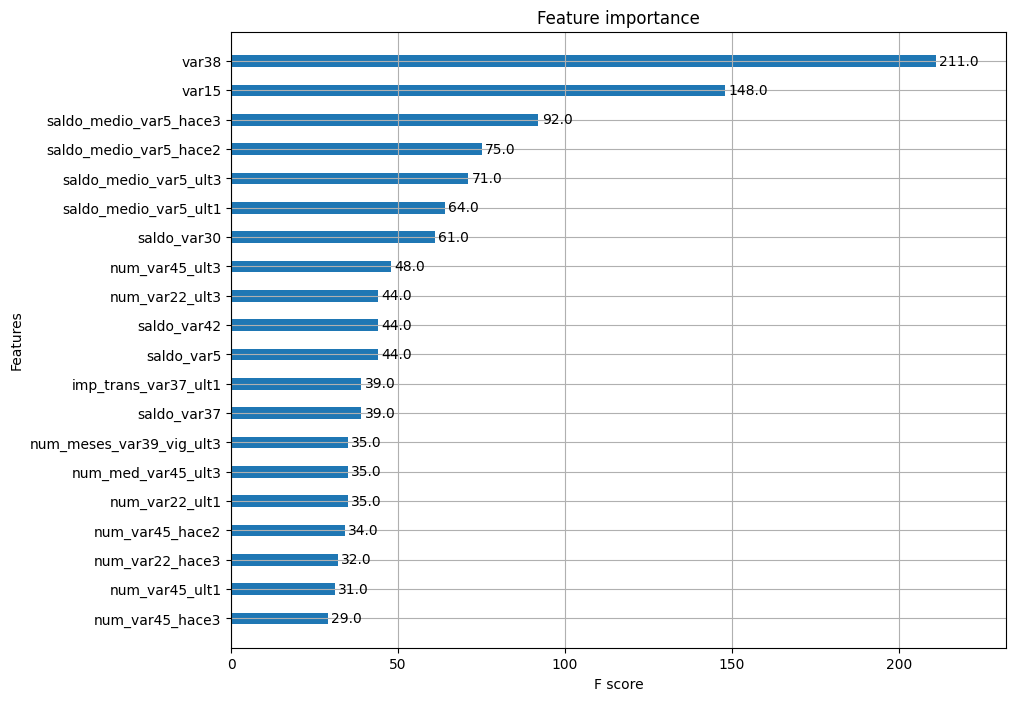

In [90]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [97]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(
    n_estimators=500
    , early_stopping_round=100
    , metric='auc'
    )

eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(
      X_tr
    , y_tr
    , eval_set=eval_set
    )

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.925273	valid_1's auc: 0.831952
ROC AUC: 0.8377


In [98]:
lgbm_search_space = {
      'num_leaves': hp.quniform('num_leaves', 32, 64, 1)
    , 'max_depth': hp.quniform('max_depth', 100, 160, 1)
    , 'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1)
    , 'subsample': hp.uniform('subsample', 0.7, 1)
    , 'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [102]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(
          n_estimators=100
        , num_leaves=int(search_space['num_leaves'])
        , max_depth=int(search_space['max_depth'])
        , min_child_samples=int(search_space['min_child_samples'])
        , subsample=search_space['subsample']
        , learning_rate=search_space['learning_rate']
        , early_stopping_round=30
        , metric='auc'
    )
    roc_auc_list = []
    
    kf = KFold(n_splits=3)
    for tr_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        lgbm_clf.fit(
              X_tr
            , y_tr
            , eval_set=[(X_tr, y_tr), (X_val, y_val)]
        )
        
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    return -1 * np.mean(roc_auc_list)

In [103]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(
      fn=objective_func
    , space=lgbm_search_space
    , algo=tpe.suggest
    , max_evals=50
    , trials=trials
    , rstate=np.random.default_rng(seed=30)
)

print('best:', best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827                    
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872 
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:       
[98]	training's auc: 0.88765	valid_1's auc: 0.831519
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

In [104]:
lgbm_clf = LGBMClassifier(
      n_estimators=500
    , num_leaves=int(best['num_leaves'])
    , max_depth=int(best['max_depth'])
    , min_child_samples=int(best['min_child_samples'])
    , subsample=round(best['subsample'], 5)
    , learning_rate=round(best['learning_rate'], 5)
    , early_stopping_round=100
    , metric='auc'
)

lgbm_clf.fit(
      X_tr
    , y_tr
    , eval_set=[(X_tr, y_tr), (X_val, y_val)]
)

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13001
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 202
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	training's auc: 0.889143	valid_1's auc: 0.832589
ROC AUC: 0.8453


### 분류 실습 - 캐글 신용카드 사기 검출

##### 언더 샘플링과 오버 샘플링의 이해


##### 데이터 일차 가공 및 모델 학습/예측/평가

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [129]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [130]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
          X_features
        , y_target
        , test_size=0.3
        , random_state=0
        , stratify=y_target
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [131]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [132]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8585, 재현율: 0.6149, F1: 0.7165, AUC: 0.9736


In [133]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [134]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(
      n_estimators=1000
    , num_leaves=64
    , n_jobs=-1
    , boost_from_average=False
)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

##### 데이터 분포도 변환 후 모델 학습/예측/평가

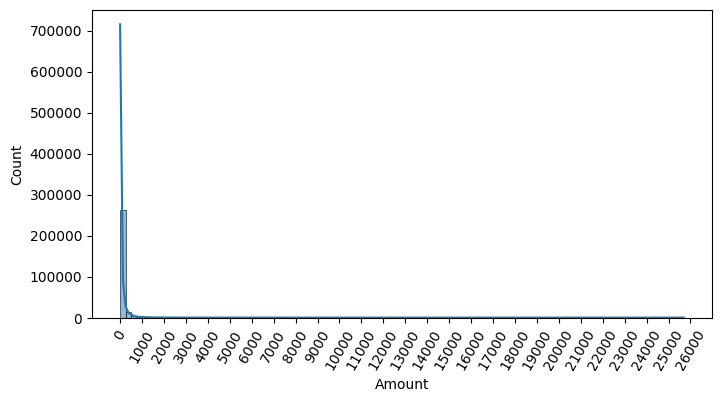

In [135]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [136]:
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [140]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1: 0.7120, AUC: 0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [138]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [139]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(
    lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test
)

print('### LightGBM  예측 성능 ###')
get_model_train_eval(
    lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test
)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1: 0.7120, AUC: 0.9734
### LightGBM  예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

##### 이상치 데이터 제거 후 모델 학습/예측/평가

<Axes: >

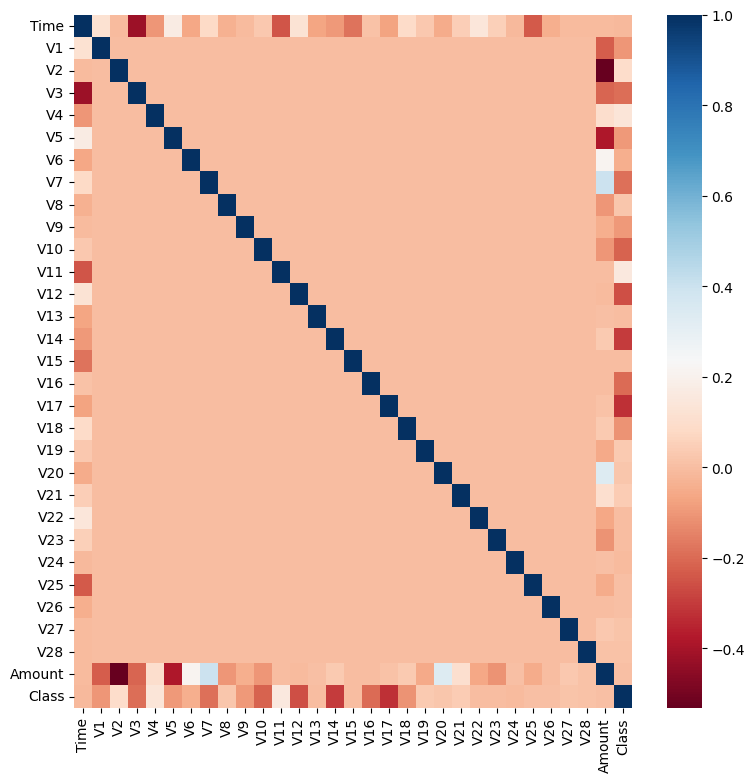

In [141]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [142]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [149]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [150]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(
      lr_clf
    , ftr_train=X_train
    , ftr_test=X_test
    , tgt_train=y_train
    , tgt_test=y_test
)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(
      lgbm_clf
    , ftr_train=X_train
    , ftr_test=X_test
    , tgt_train=y_train
    , tgt_test=y_test
)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1: 0.7568, AUC: 0.9725
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

##### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [151]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [152]:
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(
      lr_clf
    , ftr_train=X_train_over
    , ftr_test=X_test
    , tgt_train=y_train_over
    , tgt_test=y_test
)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1: 0.1022, AUC: 0.9736


In [156]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

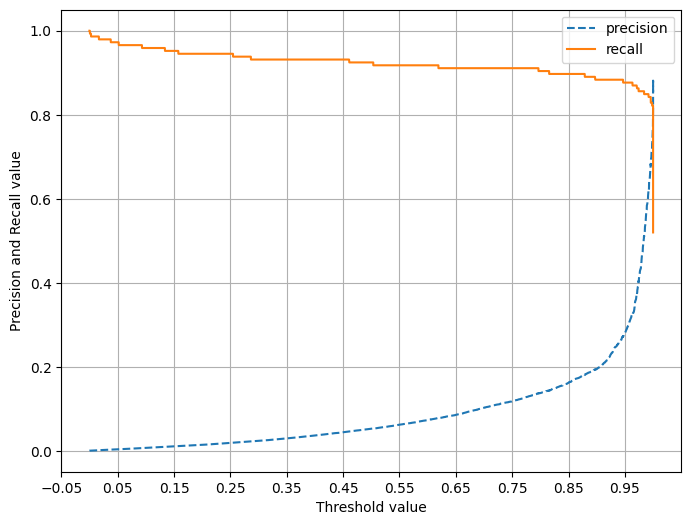

In [157]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [158]:
lgbm_clf = LGBMClassifier(
      n_estimators=1000
    , num_leaves=64
    , n_jobs=-1
    , boost_from_average=False
)
get_model_train_eval(
      lgbm_clf
    , ftr_train=X_train_over
    , ftr_test=X_test
    , tgt_train=y_train_over
    , tgt_test=y_test
)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

### 11 스태킹 앙상블

##### 기본 스태킹 모델

In [159]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(
      X_data
    , y_label
    , test_size=0.2
    , random_state=0
)

In [160]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression()

In [161]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [162]:
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
# gbm_pred = gbm_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


In [164]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [166]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


##### CV 세트 기반의 스태킹

In [171]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    return train_fold_pred, test_pred_mean

In [172]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [173]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [174]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
